# MCM-C题——国家聚类部分

**聚类策略：**  
- 先做一步K-means粗聚类，且K值选的比较大，50～100，这样可以把用户分成很多类，在此选择50  
- 提取K-means的质心，然后再做一步层次聚类，这样可以把用户分成更细致的类别，分成m类  
- 如果m比较大，可以再做一步SOM聚类，使类别数k小于10  
- 最后用确定的k类个中心，作为起始类中心，再使用K-means

In [1]:
import pandas as pd
import category_encoders as ce
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from minisom import MiniSom
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, Isomap, LocallyLinearEmbedding, TSNE, SpectralEmbedding

## 一、数据导入

In [2]:
X = pd.read_csv('./cluster.csv')
X.head()

,NOC,Gold,Silver,Bronze,Total
0,USA,40,44,42,126
1,CHN,40,27,24,91
2,JPN,20,12,13,45
3,AUS,18,19,16,53
4,FRA,16,26,22,64


**选择'Gold', 'Silver', 'Bronze', 'Total'用于聚类**

In [3]:
X_cluster = X[['Gold', 'Silver', 'Bronze', 'Total']]

## 二、国家聚类
### 2.1 K-means粗聚类
首先，采用 K-means 算法进行初步粗聚类。为了更全面地覆盖用户的多样性，将 K 值设定在 50 至 100 的较大范围内，本研究中具体选择 K 值为 50。通过这一步骤，能够将用户初步划分成 50 个类别，这为后续的分析提供了一个较为宽泛的基础框架，初步揭示用户群体的大致分布。

In [4]:
kmeans = KMeans(n_clusters=50, random_state=42, n_init=10)
kmeans.fit(X_cluster)
centroids = kmeans.cluster_centers_

### 2.2 层次聚类
接着，提取第一步 K-means 聚类得到的 50 个质心。这些质心代表了每个初步聚类簇的核心特征，将其作为新的数据点输入到层次聚类算法中。层次聚类在此分为两个关键步骤：
#### 2.2.1 凝聚式聚类法
在凝聚式层次聚类算法中，初始时将每个数据点视为一个独立的类。随后，算法不断迭代，每次迭代都合并相似度最高的两个类。  
- 在这一过程中，样本点之间的距离度量采用欧氏距离:  
对于两个样本点 $X = (x_1, x_2, \ cdot ,x_n) $ 和 $Y = (y_1, y_2, \ cdot ,y_n) $，它们之间的欧氏距离 $ d(X,Y)$ 定义为：
$$ d(\mathbf{x}, \mathbf{y}) = \sqrt{\sum_{i = 1}^{n}(x_i - y_i)^2}$$
- 而簇与簇之间的距离则使用 Ward 距离:  
设$C_i$和$C_j$为两个簇，$n_i$和$n_j$分别为这两个簇中的样本数量，$\bar {x_i}$和$\bar {x_j}$分别为两个簇的质心。Ward 距离$D_W(C_i,C_j)$ 定义为：
$$D_{W}(C_i, C_j) = \frac{n_i n_j}{n_i + n_j} \| \mathbf{\overline{x}}_i - \mathbf{\overline{x}}_j \|^2$$
其中，$\|\cdot\|$ 表示欧氏范数。在上述公式中，若 $\mathbf{\overline{x}}_i = (\overline{x}_{i1},\overline{x}_{i2},\cdots,\overline{x}_{in})$ 和 $\mathbf{\overline{x}}_j = (\overline{x}_{j1},\overline{x}_{j2},\cdots,\overline{x}_{jn})$，则 $\|\mathbf{\overline{x}}_i - \mathbf{\overline{x}}_j\|^2 = \sum_{k = 1}^{n}(\overline{x}_{ik} - \overline{x}_{jk})^2$。$$$

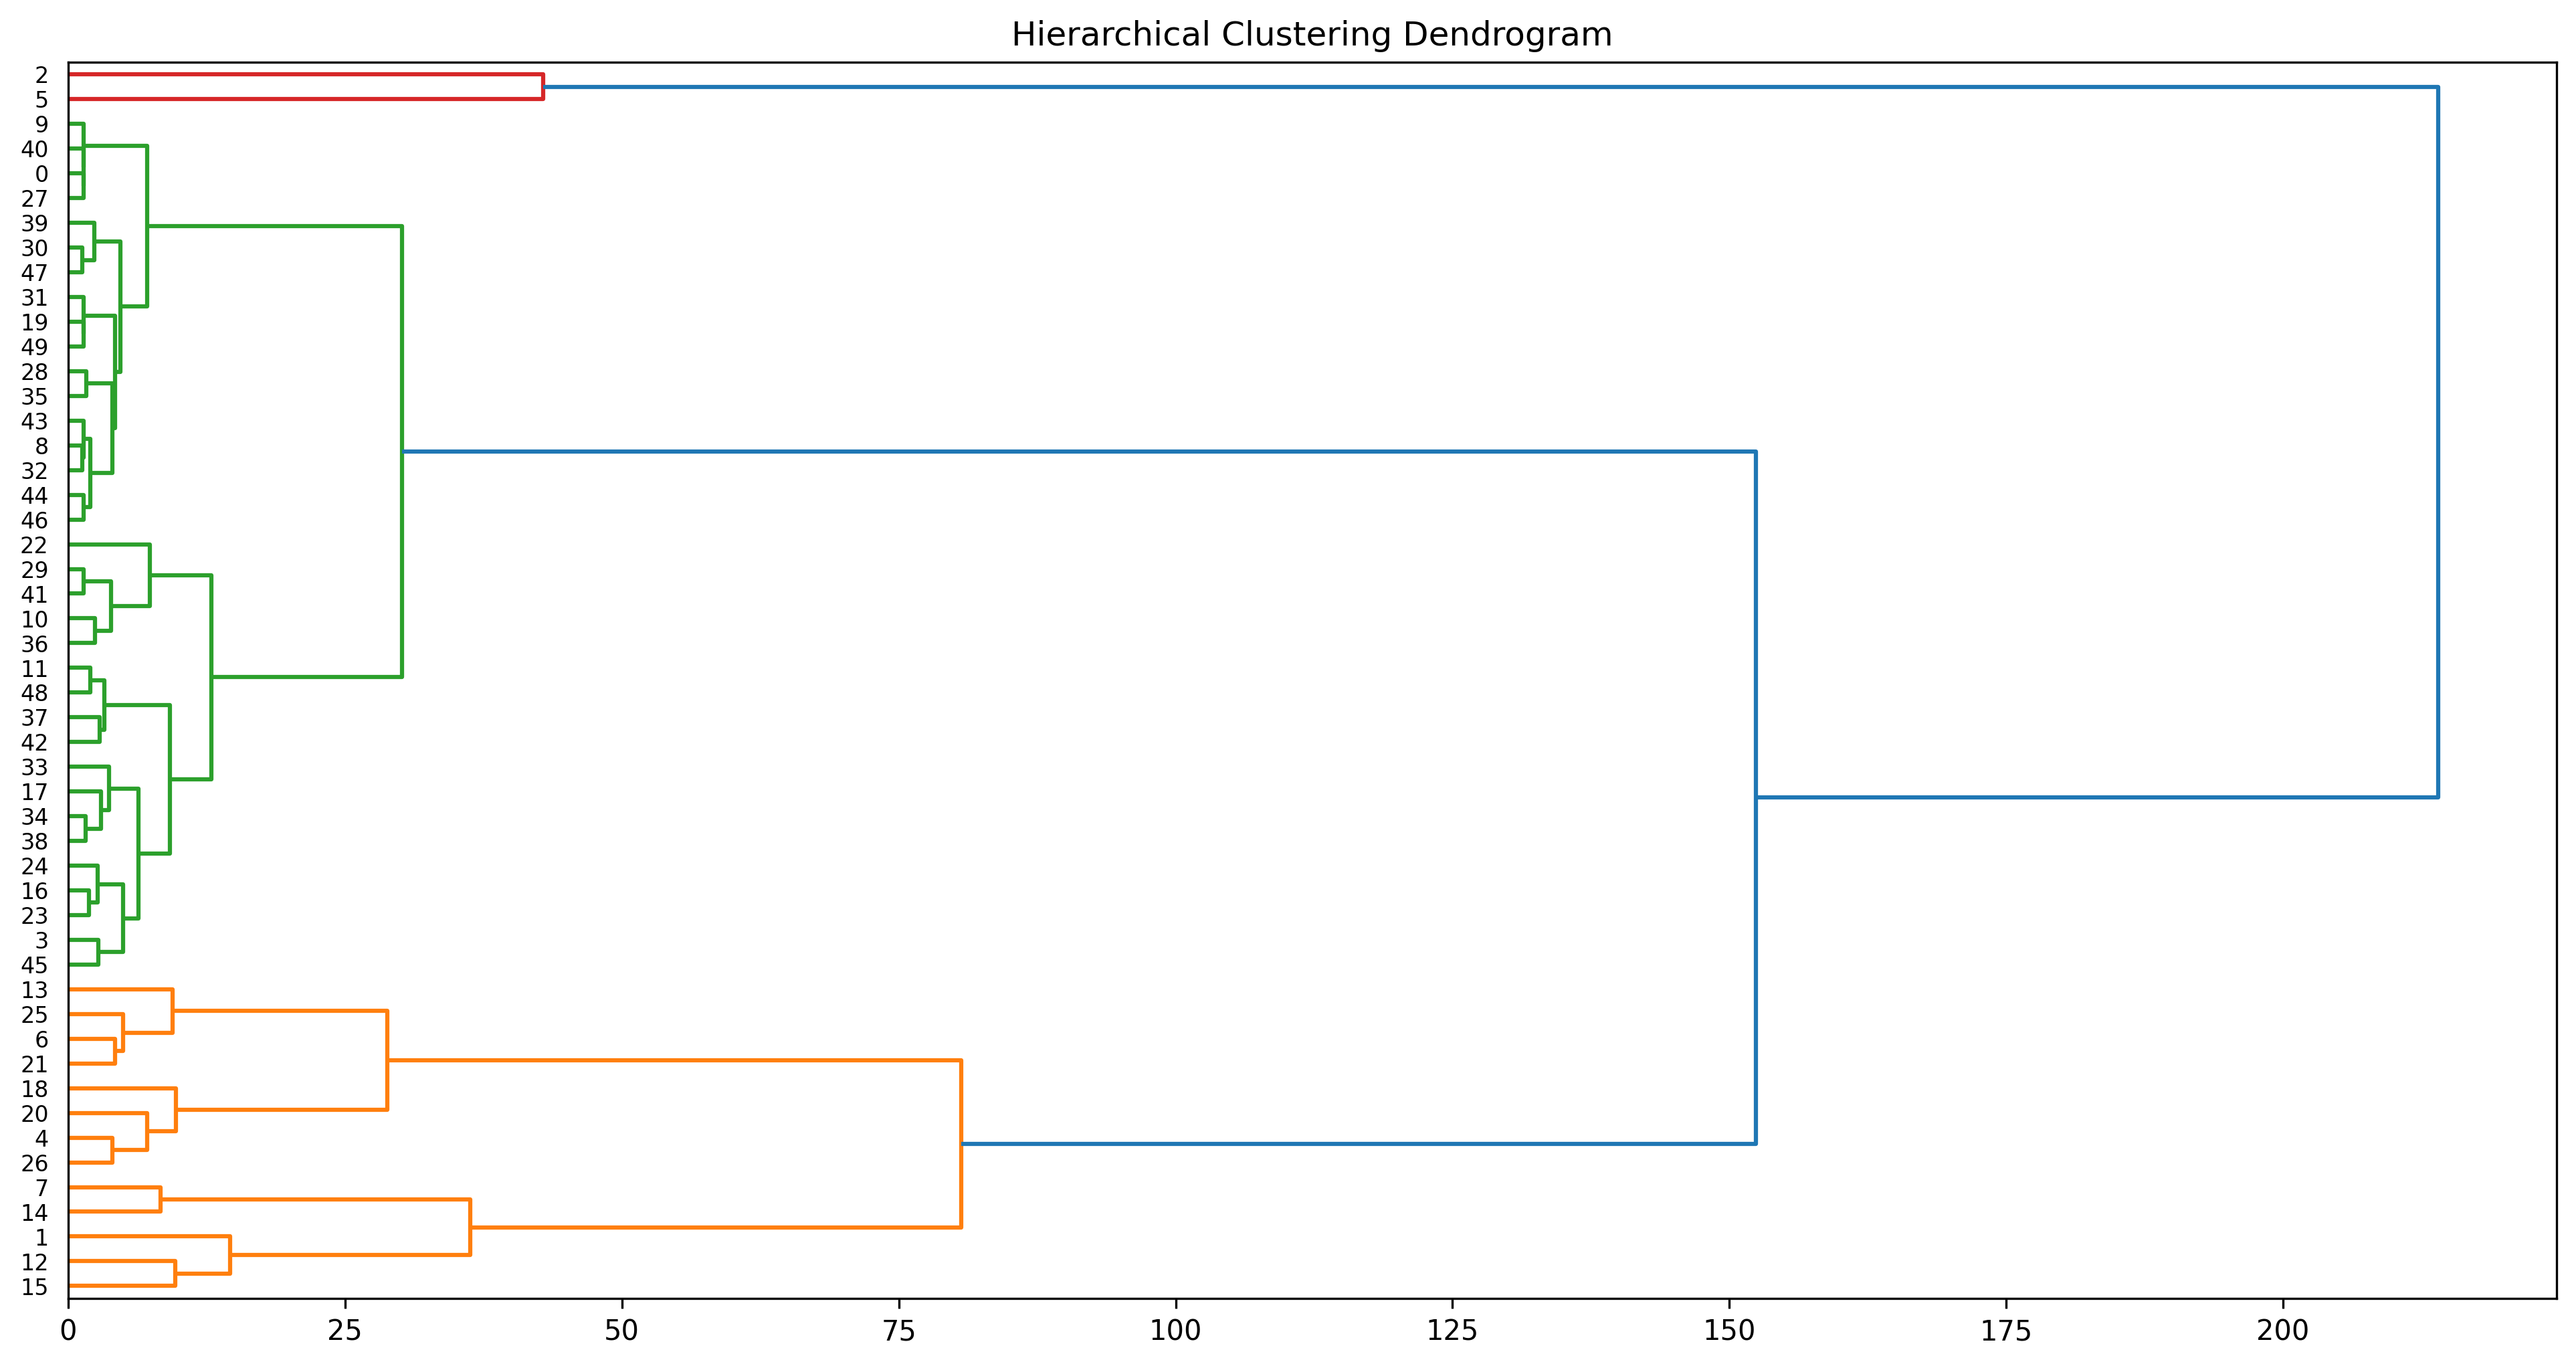

In [5]:
# 对KMeans的50个质心做层次聚类
agg_clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=0)
agg_clustering.fit(centroids)

# 绘制谱系图
linked = linkage(centroids, 'ward')
plt.figure(figsize=(16, 8),dpi=300)
dendrogram(linked, orientation='right', distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.savefig(fname="层次聚类谱系图.png")

#### 2.2.2 基于伪T方和伪F的最佳类数确定
在凝聚式聚类法生成一系列不同类数的聚类结果后，利用伪T方（Pseudo $T^2$）和伪F（Pseudo F）统计量来评估每个聚类结果的质量。伪 T 方反映了类内方差与类间方差的比值，其值越大，说明类内的紧凑性和类间的分离性越好，计算公式为：
$$T^2 = \frac{\sum_{i = 1}^{g} n_i (\bar{X}_i - \bar{X})^T \sum^{-1} (\bar{X}_i - \bar{X})}{g - 1}$$
其中 $n_i$ 是第 $i$ 类的样本数量 ，$\bar{X}_i$ 是第 $i$ 类的均值向量，$\bar{X}$ 是总体均值向量，$\sum$ 是总体协方差矩阵，$g$ 是类别数。  
伪F统计量则综合考虑了类内和类间的变化，通过计算类间平方和与类内平方和的比值来衡量聚类的效果，较高的伪F值意味着聚类结果更优，计算公式为：
$$F = \frac{\frac{\sum_{i = 1}^{g} n_i (\bar{X}_i - \bar{X})^T \sum^{-1} (\bar{X}_i - \bar{X})}{g - 1}}{\frac{\sum_{i = 1}^{g} \sum_{j = 1}^{n_i} (X_{ij} - \bar{X}_i)^T \sum^{-1} (X_{ij} - \bar{X}_i)}{N - g}}$$
其中 $X_{ij}$ 表示第 $i$ 类中的第 $j$ 个样本，$N$ 是总的样本数量。  
通过遍历不同类数下的伪 T 方和伪 F 值，选择使得这两个统计量达到最优平衡时对应的类数，作为最终的类别数 m。这种基于统计量的最佳类数确定方法，能够避免主观判断的偏差，使得聚类结果在准确性和合理性上更具说服力。

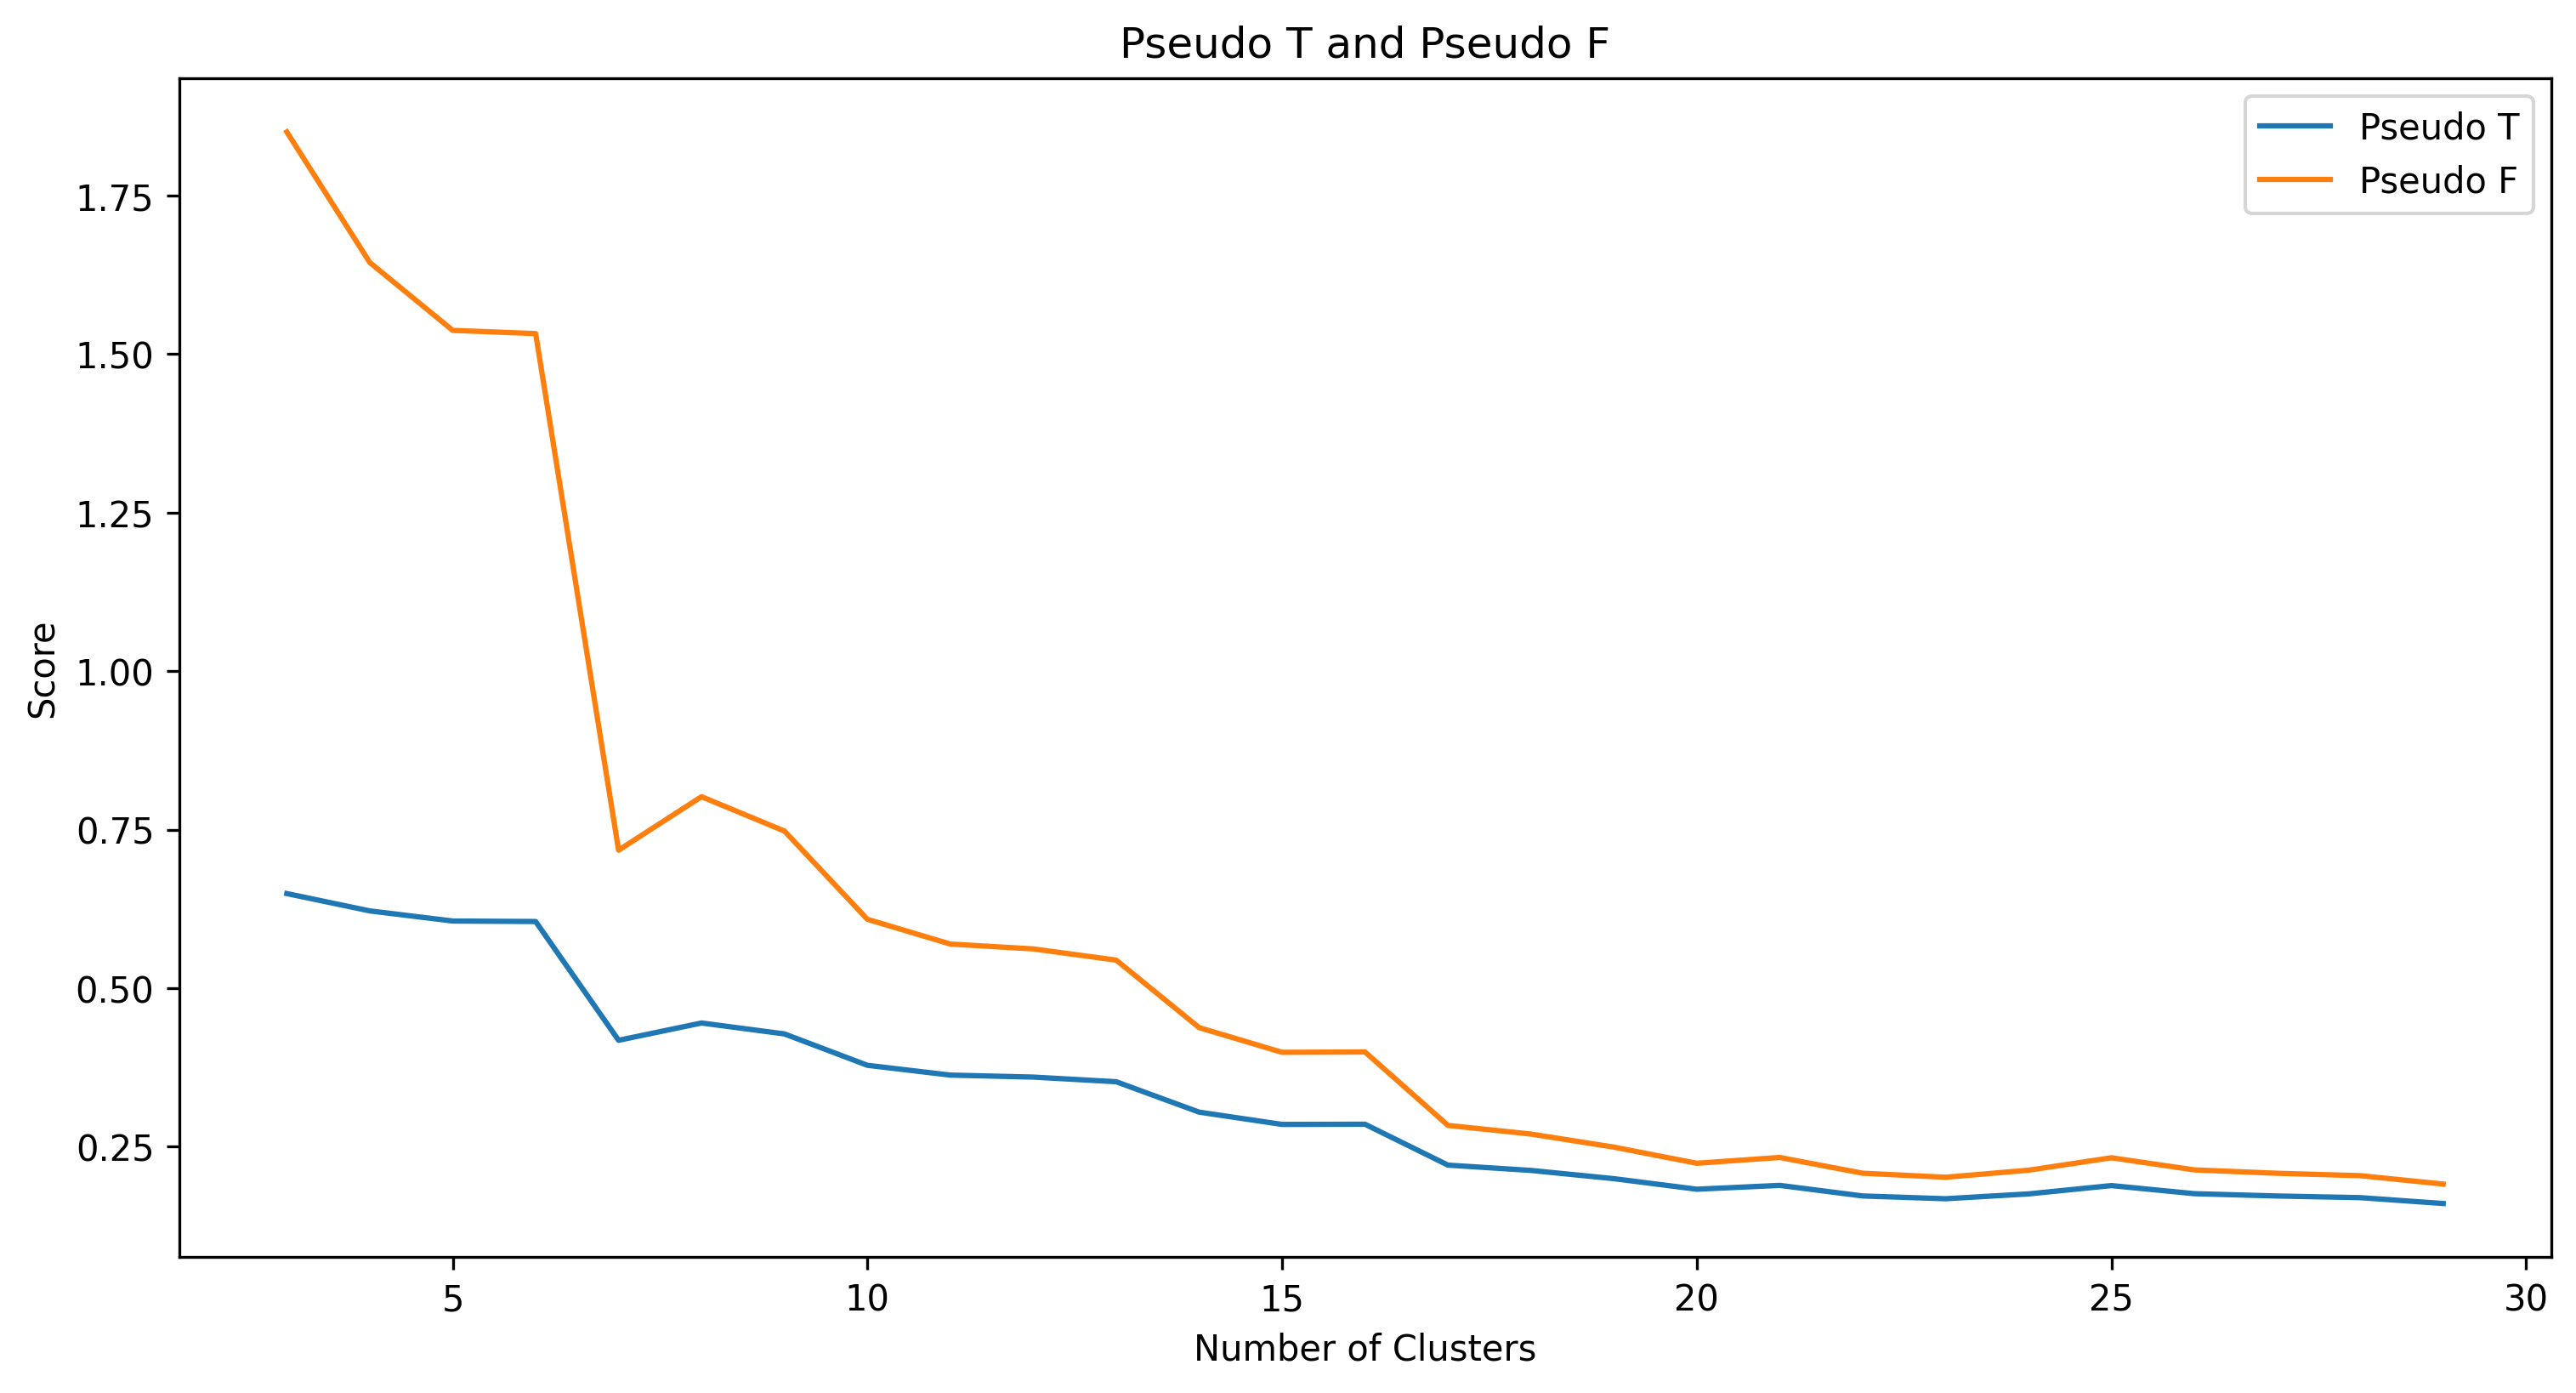

In [6]:
def calculate_pseudo_t_f(agg_clustering, centroids):
    n_clusters = np.arange(3, 30)
    pseudo_t = []
    pseudo_f = []
    for n in n_clusters:
        agg_clustering.set_params(n_clusters=n, distance_threshold=None)
        labels = agg_clustering.fit_predict(centroids)
        silhouette_avg = silhouette_score(centroids, labels)
        pseudo_t.append(silhouette_avg)
        pseudo_f.append(silhouette_avg / (1 - silhouette_avg))
    return n_clusters, pseudo_t, pseudo_f

n_clusters, pseudo_t, pseudo_f = calculate_pseudo_t_f(agg_clustering, centroids)

plt.figure(figsize=(12, 6),dpi=300)
plt.plot(n_clusters, pseudo_t, label='Pseudo T')
plt.plot(n_clusters, pseudo_f, label='Pseudo F')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Pseudo T and Pseudo F')
plt.legend()
plt.savefig(fname="伪t方-伪f曲线.png")

**最佳聚类数**

In [7]:
m = n_clusters[np.argmax(pseudo_f)]
agg_clustering.set_params(n_clusters=m, distance_threshold=None)
agg_labels = agg_clustering.fit_predict(centroids)

print("最佳类数m：", m)

最佳类数m： 3


### 2.3 SOM聚类
若通过层次聚类得到的类别数 m 较大，可能会导致聚类结果过于复杂，不利于实际应用和分析。此时，引入自组织映射（SOM）聚类算法对结果进行进一步优化。SOM 算法能够将高维数据映射到低维的二维平面上，同时保持数据点之间的拓扑关系，从而实现数据的聚类。通过 SOM 聚类，将类别数进一步压缩，使得最终的类别数 k 小于 10，这样得到的聚类结果更加简洁明了，便于后续的深入分析和应用。

In [8]:
som = MiniSom(x=2, y=2, input_len=centroids.shape[1], sigma=1.0, learning_rate=0.5)
som.random_weights_init(centroids)
som.train_random(centroids, 100)

som_centroids = np.array([som.get_weights()[i][j] for i in range(2) for j in range(2)])

som_cluster_count = len(som_centroids)
print("SOM聚类后的类别数:", som_cluster_count)
print("SOM的质心：", som_centroids)

SOM聚类后的类别数: 4
SOM的质心： [[ 8.65510204  7.50584878  8.87808853 25.03903935]
 [24.64124955 21.84530336 20.76738635 67.25393926]
 [ 1.24891727  0.93718432  2.03401486  4.22011644]
 [ 4.87771225  3.54042607  3.93485874 12.35299706]]


### 2.4 K-means聚类
最后，将经过 SOM 聚类确定的 k 个类中心，作为新一轮 K - means 聚类的起始类中心。再次使用 K - means 算法，能够在已有聚类结果的基础上，进一步优化聚类效果，使得每个聚类簇内的数据点更加紧密，簇间差异更加明显。

In [9]:
kmeans_final = KMeans(n_clusters=4, init=som_centroids, n_init=1, random_state=42)
kmeans_final.fit(X_cluster)

final_cluster_count = kmeans_final.n_clusters
print("最终K-means聚类后的类别数:", final_cluster_count)

final_labels = kmeans_final.labels_
print("最终用户分群结果：", final_labels)

X['Cluster'] = final_labels
X.to_csv('clustered_results.csv', index=False)

最终K-means聚类后的类别数: 4
最终用户分群结果： [1 1 0 0 1 0 1 0 0 0 3 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 3 3 3 3 2 2 3 2 2
 2 2 2 3 3 3 3 3 3 2 3 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 3 3 2 3 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


### 2.5 基于Manifold的聚类可视化
####  t-SNE算法
**算法原理**：
- 高维空间相似性计算：在高维空间中，t-SNE 采用条件概率来衡量数据点之间的相似性。对于高维空间中的点$x_i$和$x_j$，点$x_j$是点$x_i$的邻居的概率$p_{j|i}$的公式：
  $$p_{j|i}=\frac{\exp\left(-\frac{\lVert x_{i}-x_{j}\rVert^{2}}{2\sigma_{i}^{2}}\right)}{\sum_{k\neq i}\exp\left(-\frac{\lVert x_{i}-x_{k}\rVert^{2}}{2\sigma_{i}^{2}}\right)}$$
  其中$\sigma_i$是针对点$x_i$的高斯分布的标准差，反映了点的局部邻域范围。为使相似性对称，使用$p_{ij}=\frac{p_{j|i}+p_{i|j}}{2n}$，$n$是数据点总数。
- 低维空间相似性计算：在低维空间中，t-SNE使用t分布来定义点对之间的相似性。对于低维空间中的点$y_i$和$y_j$，其相似性定义为:
  $$q_{ij}=\frac{(1 + \lVert y_{i}-y_{j}\rVert^{2})^{-\frac{1}{2}}}{\sum_{k\neq l}(1 + \lVert y_{k}-y_{l}\rVert^{2})^{-\frac{1}{2}}}$$
- 目标函数与优化：t-SNE 通过最小化高维空间与低维空间中分布之间的 Kullback - Leibler（KL）散度来优化嵌入，目标是最小化：
  $$C = KL(P||Q)=\sum_{i}\sum_{j}p_{ij}\log\left(\frac{p_{ij}}{q_{ij}}\right)$$
  本文使用梯度下降法来更新低维空间中的点位置以最小化成本函数。

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 206 samples in 0.000s...
[t-SNE] Computed neighbors for 206 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 206 / 206
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 0.008s
[t-SNE] Iteration 50: error = 40.2002029, gradient norm = 0.1219746 (50 iterations in 0.190s)
[t-SNE] Iteration 100: error = 38.4662933, gradient norm = 0.1050651 (50 iterations in 0.070s)
[t-SNE] Iteration 150: error = 38.4184074, gradient norm = 0.0855112 (50 iterations in 0.016s)
[t-SNE] Iteration 200: error = 38.4710464, gradient norm = 0.1092605 (50 iterations in 0.016s)
[t-SNE] Iteration 250: error = 38.6382256, gradient norm = 0.1514522 (50 iterations in 0.017s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 38.638226
[t-SNE] Iteration 300: error = -0.1187888, gradient norm = 0.0103808 (50 iterations in 0.020s)
[t-SNE] Iteration 350: error = -0.2982058, gradient norm = 0.013781

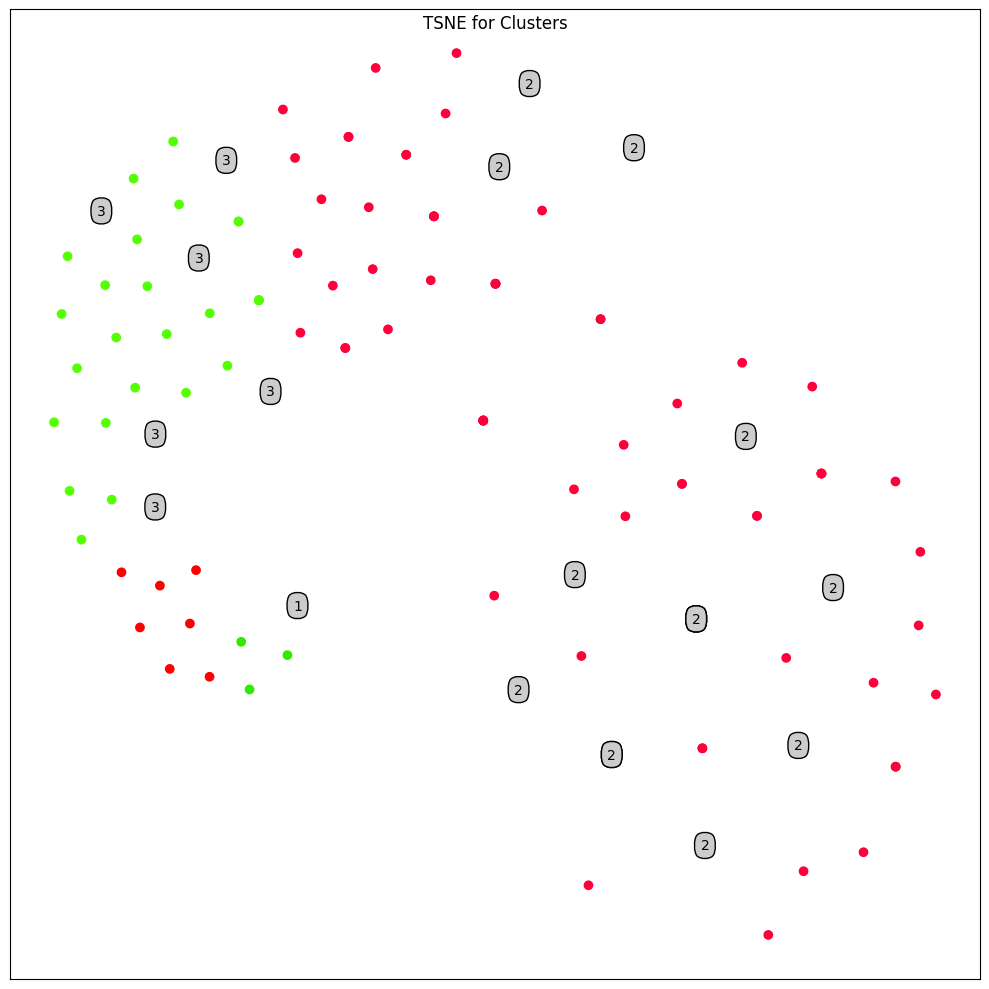

In [10]:
def visualize_clusters(X, labels, method, filename):
    fig, plot = plt.subplots()
    fig.set_size_inches(10, 10)
    plt.prism()

    X_transformed = method.fit_transform(X)
    plot.scatter(X_transformed[:, 0], X_transformed[:, 1], c=labels)
    plot.set_xticks(())
    plot.set_yticks(())

    count = 0
    plt.tight_layout()
    plt.suptitle(f"{method.__class__.__name__} for Clusters")
    for label, x, y in zip(labels, X_transformed[:, 0], X_transformed[:, 1]):
        if count % 10 == 0:
            plt.annotate(str(int(label)), xy=(x, y), color='black', weight='normal', size=10, bbox=dict(boxstyle="round4,pad=.5", fc="0.8"))
        count += 1
    plt.savefig(filename, dpi=300)

visualize_clusters(X_cluster, final_labels, TSNE(n_components=2, perplexity=40, verbose=2), "clusters_tsne.png")

**其他相对效果没那么好的可视化结果**

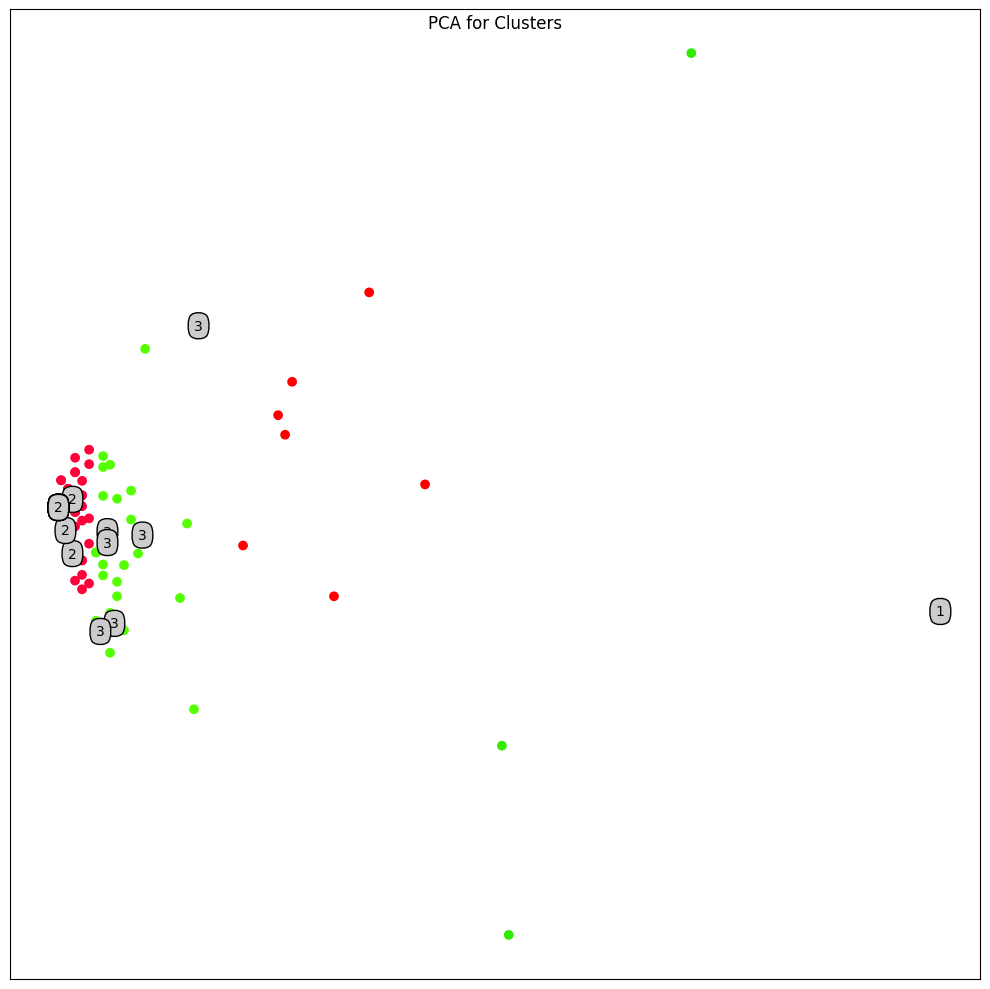

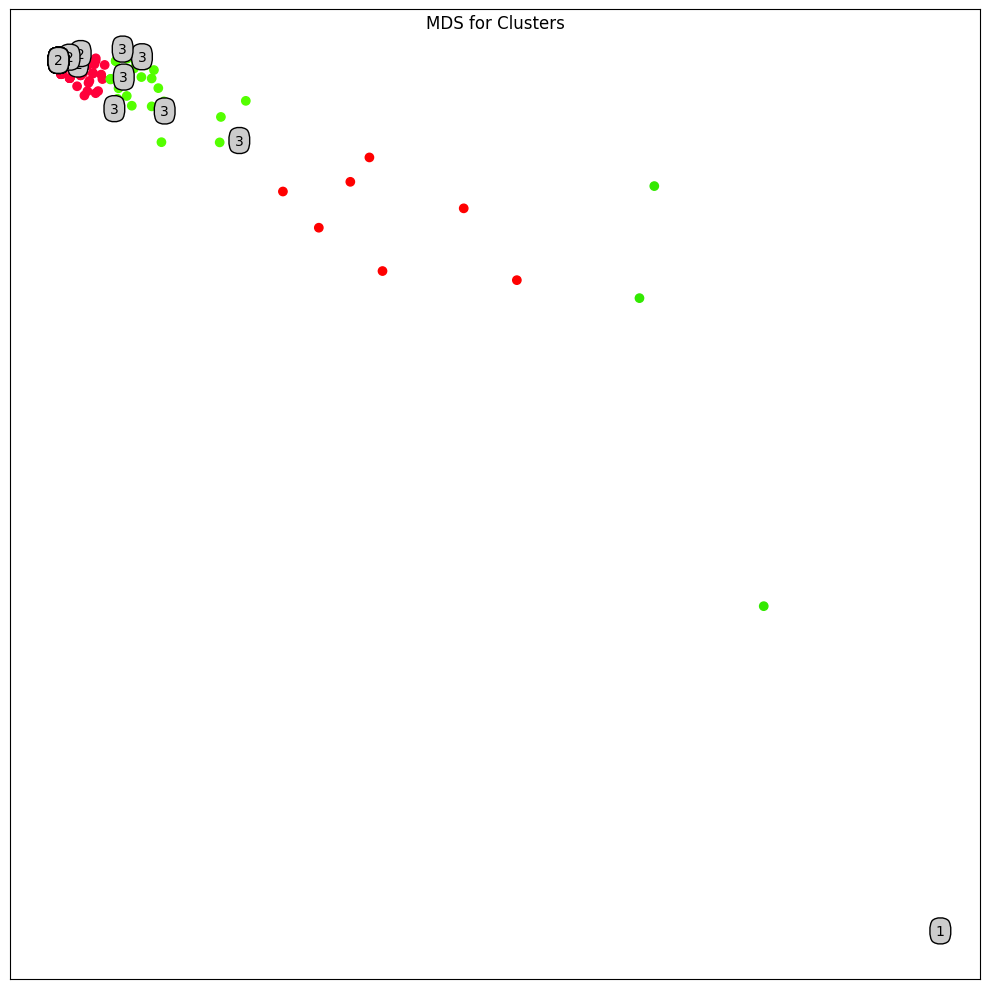

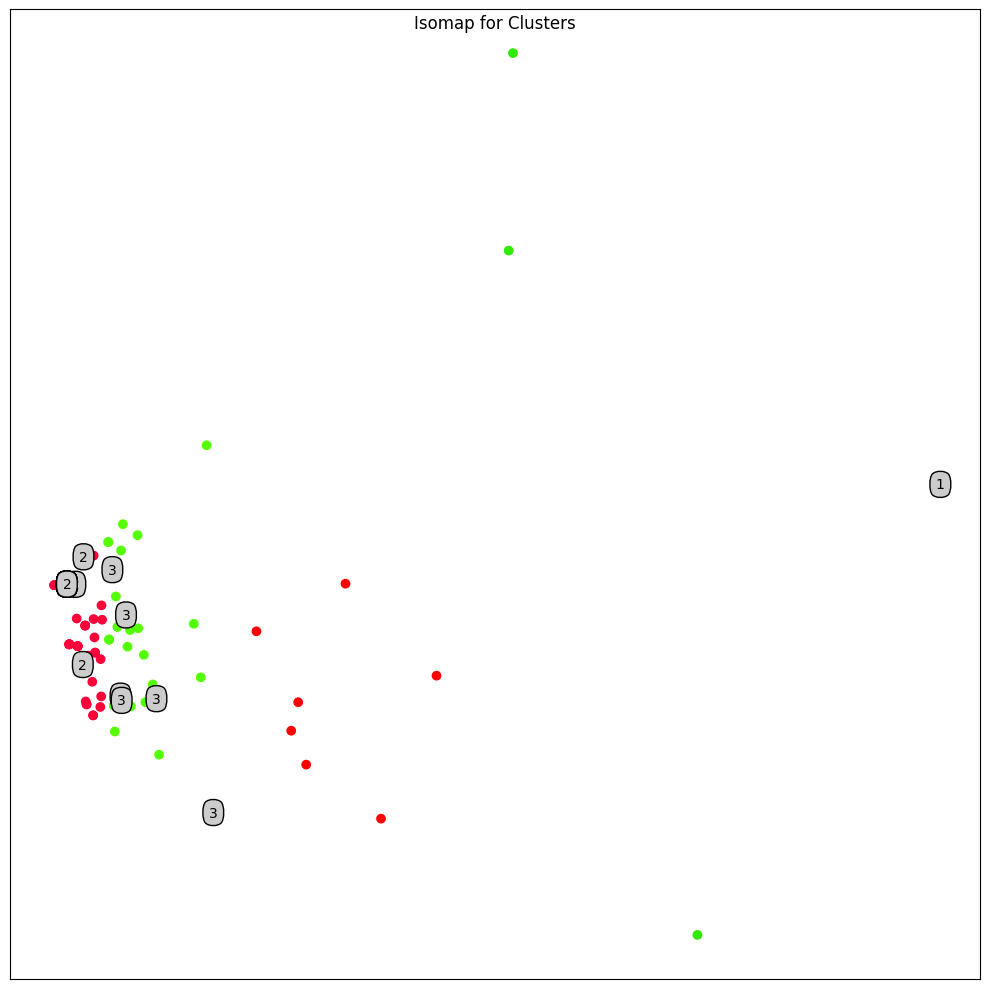

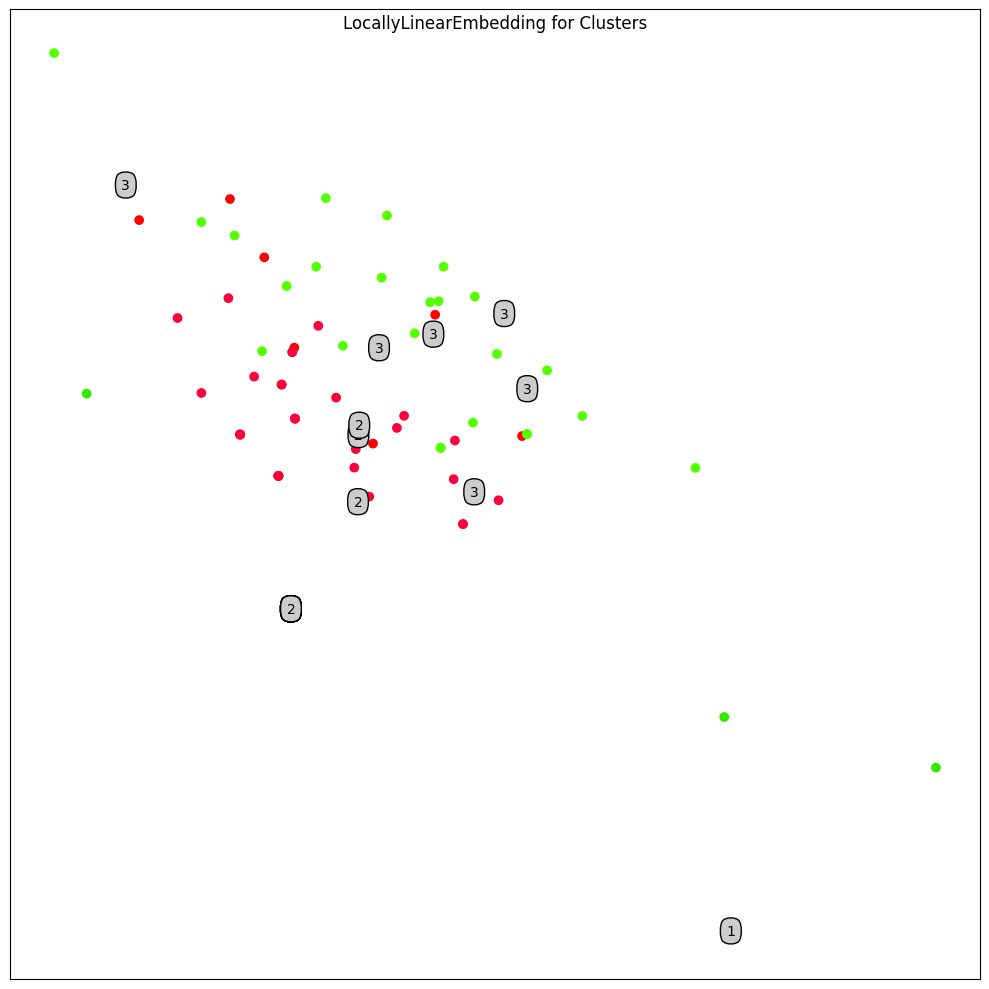

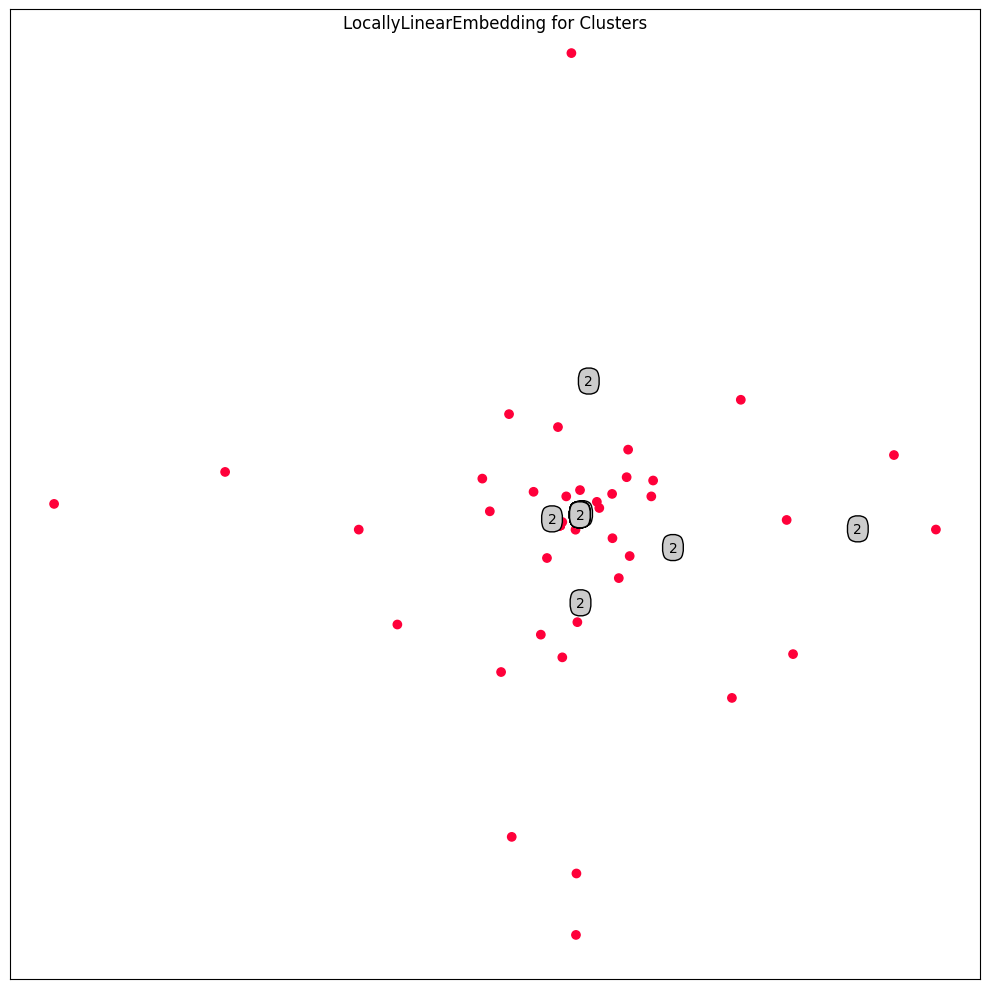

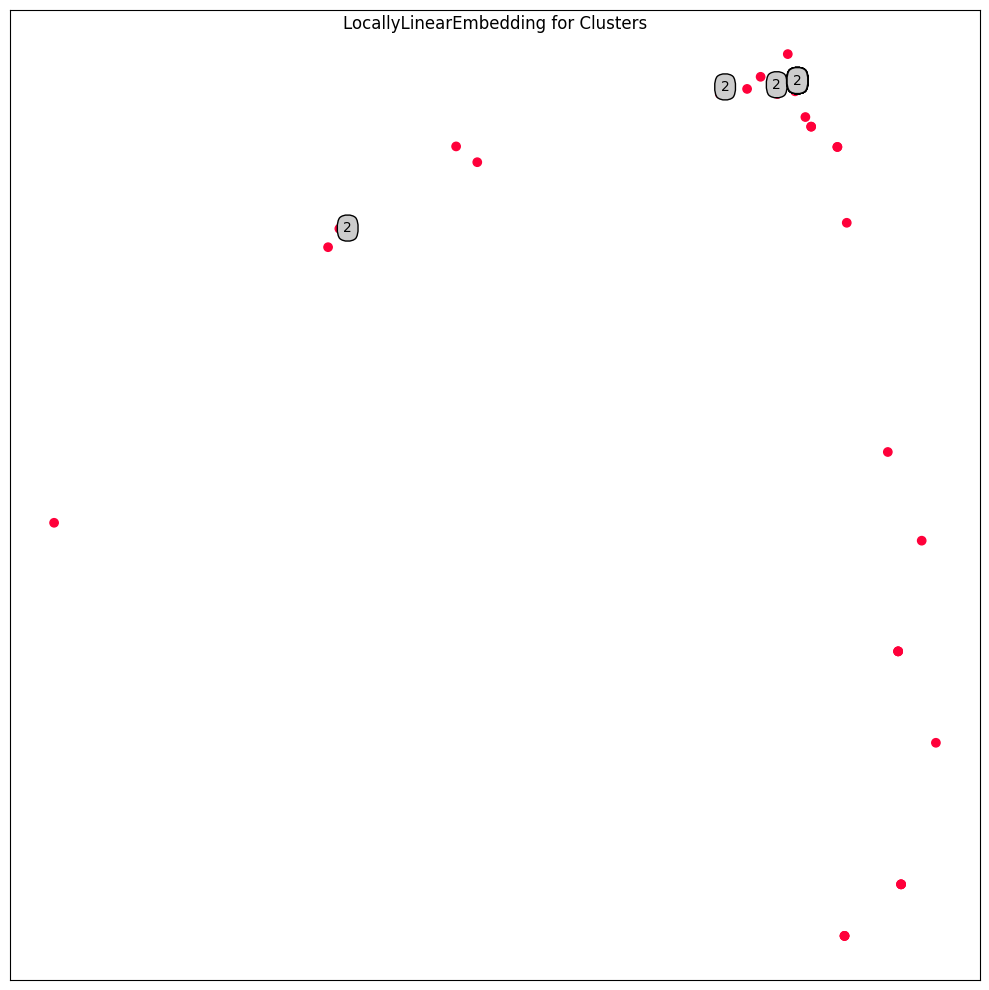

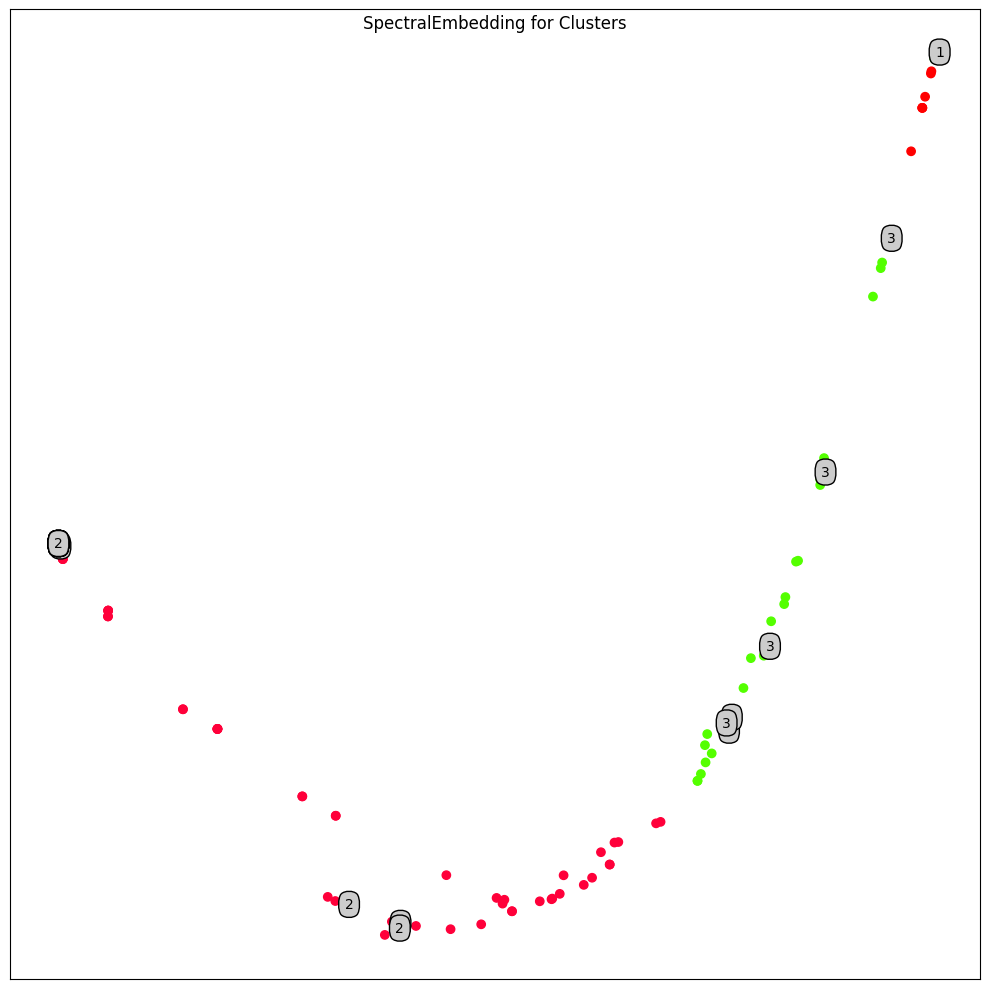

In [11]:
# PCA
visualize_clusters(X_cluster, final_labels, PCA(n_components=2), "clusters_pca.png")

# MDS
visualize_clusters(X_cluster, final_labels, MDS(n_components=2, max_iter=100, n_init=1, normalized_stress='auto'), "clusters_mds.png")

# Isomap
visualize_clusters(X_cluster, final_labels, Isomap(n_neighbors=10, n_components=2), "clusters_isomap.png")

# LLE
visualize_clusters(X_cluster, final_labels, LocallyLinearEmbedding(n_neighbors=10, n_components=2, eigen_solver='dense', method='standard'), "clusters_lle.png")

# # MLLE
# visualize_clusters(X_cluster, final_labels, LocallyLinearEmbedding(n_neighbors=10, n_components=2, eigen_solver='dense', method='modified'), "clusters_mlle.png")

# HLLE
visualize_clusters(X_cluster, final_labels, LocallyLinearEmbedding(n_neighbors=10, n_components=2, eigen_solver='dense', method='hessian'), "clusters_hlle.png")

# LTSA
visualize_clusters(X_cluster, final_labels, LocallyLinearEmbedding(n_neighbors=10, n_components=2, eigen_solver='dense', method='ltsa'), "clusters_ltsa.png")

# Spectral Embedding
visualize_clusters(X_cluster, final_labels, SpectralEmbedding(n_components=2, n_neighbors=10), "clusters_spectral.png")